# AI and EO for the Prediction of Malaria Outbreak Risk
- Presenting Institution: [isardSAT Ltd.](https://www.isardsat.cat/)
- Challenge: Using earth observation data to generate a malaria risk infection map at global scale in order to prevent epidemic episodes.

Key factors influencing malaria-transmitting mosquito populations:
1. Temperature
  - Ideal hatching water temperature: 24-30 degrees C
  - Ideal evolution from hatching water temperature: 22-26 degrees C
  - Optimum air temperature for malaria-bearing mosquitoes: 25-30 degrees C
  - Mosquitos typically don't survive below 15 degrees C nor above 40 degrees C
2. Standing Water
  - Mosquito eggs take 10-14 days to incubate
  - Frequency and amplitude of rainfall
  - Should take evaporation rates, humidity into account
  - Could use radar altimetry to detect large bodies of water, as well as meteorological data, soil moisture as proxy
3. Elevation
  - Mosquitos don't typically live at altitudes above 1500m
4. Water Quality
5. Land Use
  - Urban vs. Rural
6. Buffer Zone
  - Distance from suspected contamination zone (greater distance, reduced risk)

## Read the data from the .csv file
Data sources:
- [NASA's MODIS/Terra Land Surface Temperature/Emissivity Daily L3 Global 1 km SIN Grid](https://lpdaac.usgs.gov/products/mod11a1v006/)
- [ESA's Soil Moisture and Ocean Salinity (SMOS)](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/smos/content/-/asset_publisher/t5Py/content/data-types-levels-formats-7631)
- [NASA's SMAP Enhanced L3 Radiometer Global Daily 9 km EASE-Grid Soil Moisture, Version 2](https://nsidc.org/data/SPL3SMP_E)
- [Global 30 Arc-Second Elevation (GTOPO30)](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-30-arc-second-elevation-gtopo30?qt-science_center_objects=0#qt-science_center_objects)

Note that Daytime Land Surface Temperature `LST_Day_1km` are measured in Kelvin and require a scale factor of 0.02.

In [1]:
from __future__ import print_function
import os
# Please set the path below as per your system data folder location
data_path = ['data', 'temp_smos', '2016-09-15_to_2019-05-24']

Let's list the contents of our raw data directory. We have 2 sets of measurements for each of our 8 study locations in Africa.

In [2]:
filenames = os.listdir(path=os.sep.join(data_path))
filenames

['smos_bushbuckridge.csv',
 'smos_chimoio.csv',
 'smos_inhambane.csv',
 'smos_mawanga.csv',
 'smos_thabazimbi.csv',
 'smos_tzaneen.csv',
 'smos_vilaMachado.csv',
 'smos_yatya.csv',
 'temp_bushbuckridge.csv',
 'temp_chimoio.csv',
 'temp_inhambane.csv',
 'temp_mawanga.csv',
 'temp_thabazimbi.csv',
 'temp_tzaneen.csv',
 'temp_vilaMachado.csv',
 'temp_yatya.csv']

We want to combine the files providing temperature and soil moisture readings for each location into a single dataframe. 

In [3]:
import numpy as np
import pandas as pd

frames = []
tuples = []
for filename in filenames:
    fname, ext = filename.split('.')
    if ext == 'csv':
        filepath = os.sep.join(data_path + [filename])
        tuples.append(tuple(fname.split('_')))
        frames.append(pd.read_csv(filepath, index_col=0, header=0, names=['Date', fname], parse_dates=True))
data = pd.concat(frames, axis = 1, join = 'outer')
data.columns = pd.MultiIndex.from_tuples(tuples, names=['Measurement', 'Location'])

### Peek at the data

In [4]:
data.head()

Measurement          smos                                               \
Location    bushbuckridge chimoio inhambane mawanga thabazimbi tzaneen   
Date                                                                     
2016-09-15            NaN     NaN       NaN     NaN        NaN     NaN   
2016-09-16            NaN     NaN       NaN     NaN        NaN     NaN   
2016-09-17          7.082   7.183    11.821   3.646      3.315   8.428   
2016-09-18            NaN     NaN       NaN     NaN        NaN     NaN   
2016-09-19            NaN     NaN       NaN     NaN        NaN     NaN   

Measurement                             temp                          \
Location    vilaMachado  yatya bushbuckridge     chimoio   inhambane   
Date                                                                   
2016-09-15          NaN    NaN    15,040.628  15,492.885  15,107.829   
2016-09-16          NaN    NaN    15,325.059  15,541.461  15,194.093   
2016-09-17          3.5  3.473           NaN  15,608.289      15,104   
2016-09-18          NaN    NaN           NaN      14,945         NaN   
2016-09-19          NaN    NaN           NaN         NaN         NaN   

Measurement                                                              
Location        mawanga  thabazimbi     tzaneen vilaMachado       yatya  
Date                                                                     
2016-09-15   14,964.738  15,352.798  15,188.367  15,705.274   15,617.09  
2016-09-16   14,866.789         NaN  15,324.791  15,729.666   15,600.18  
2016-09-17   15,086.941  15,238.302   15,178.68  15,757.057  15,693.104  
2016-09-18   15,053.525         NaN         NaN         NaN         NaN  
2016-09-19   15,315.039         NaN         NaN         NaN  15,904.184

In [5]:
data.dtypes

Measurement  Location     
smos         bushbuckridge    float64
             chimoio          float64
             inhambane        float64
             mawanga          float64
             thabazimbi       float64
             tzaneen          float64
             vilaMachado      float64
             yatya            float64
temp         bushbuckridge     object
             chimoio           object
             inhambane         object
             mawanga           object
             thabazimbi        object
             tzaneen           object
             vilaMachado       object
             yatya             object
dtype: object

## Data preprocessing

The raw data in the temperature files are stored as strings giving values equal to 50 times the land surface temperature for the day across the surrounding 1km squared area of each location, measured in Kelvin. 

In [6]:
def helper(x):
    r"""Helper function to clean a string number with commas measured in 0.02 Kelvins to degrees Celsius"""
    if x is np.nan:
        return x
    else:
        return round(0.02*float(x.replace(',', '')) - 273.15, 3)

In [7]:
data['temp'] = data['temp'].applymap(helper)

In [8]:
data.dtypes

Measurement  Location     
smos         bushbuckridge    float64
             chimoio          float64
             inhambane        float64
             mawanga          float64
             thabazimbi       float64
             tzaneen          float64
             vilaMachado      float64
             yatya            float64
temp         bushbuckridge    float64
             chimoio          float64
             inhambane        float64
             mawanga          float64
             thabazimbi       float64
             tzaneen          float64
             vilaMachado      float64
             yatya            float64
dtype: object

## Visualize the data

~~We have 609 rows of data. Soil moisture is measured in intervals of 3 days from 2016-09-17 to 2018-05-16, giving 203 measurements per location. Temperature is measured daily from 2016-09-15 to 2018-05-16, but cloud cover prevents measurements, leading to missing values. Thus the number of available measurements at each of the 8 study locations ranges from 238 to 400 measurements.~~ On day 3 of the study group we were provided with soil moisture and land surface temperature datasets over a longer time period, over 1 year's worth of additional data compared to the datasets provided on day 1.

We have 980 rows of data. Soil moisture is measured in intervals of 3 days from 2016-09-17 to 2019-05-17, giving 325 measurements per location. Temperature is measured daily from 2016-09-15 to 2019-05-22, but cloud cover prevents measurements, leading to missing values. Thus the number of available measurements at each of the 8 study locations ranges from 425 to 666 measurements.

In [9]:
data.shape

(980, 16)

In [10]:
data.describe().applymap(lambda x: round(x, 3))

Measurement          smos                                                  \
Location    bushbuckridge  chimoio inhambane  mawanga thabazimbi  tzaneen   
count             325.000  325.000   325.000  325.000    325.000  325.000   
mean                4.573   10.296    10.804    4.555      7.338    7.703   
std                 3.756    5.615     4.496    3.306      5.101    3.245   
min                 1.881    3.890     3.829    1.782      2.419    3.154   
25%                 1.881    5.860     7.393    1.883      3.616    5.376   
50%                 2.747    7.894     9.114    3.509      5.240    6.648   
75%                 5.789   13.336    13.360    6.073      9.628    9.243   
max                19.300   25.258    25.400   20.328     25.329   19.686   

Measurement                               temp                              \
Location    vilaMachado    yatya bushbuckridge  chimoio inhambane  mawanga   
count           325.000  325.000       506.000  480.000   479.000  643.000   
mean             10.204    6.522        26.334   31.557    27.859   30.399   
std               6.719    5.579         4.724    5.864     3.866    7.015   
min               2.117    2.073        11.270   17.731    16.190   12.907   
25%               4.378    2.794        22.954   27.139    25.031   25.094   
50%               8.794    3.986        25.919   30.197    27.738   29.890   
75%              14.807    8.360        29.387   35.816    30.876   35.281   
max              25.400   24.968        41.335   48.427    37.460   48.197   

Measurement                                           
Location    thabazimbi  tzaneen vilaMachado    yatya  
count          666.000  493.000     425.000  640.000  
mean            29.483   27.895      33.740   37.342  
std              6.739    5.380       6.165    5.769  
min             13.465   11.570      13.710   20.507  
25%             24.030   23.918      29.227   33.236  
50%             29.169   27.659      32.446   38.062  
75%             34.555   31.540      37.701   41.790  
max             46.074   43.520      53.192   49.205

### Plot the data

After importing the required packages, we first plot summary statistics for each location using box plots for comparison. Secondly, we plot measurements at each location as time-series data.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
%matplotlib inline

sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('dark')

We reshape the data so that there is only a single measurement in each column in order to use Seaborn's boxplot method.

In [12]:
smos_plot_data = (data['smos'].stack().to_frame().reset_index().rename(columns={0:'Soil Moisture'}))
temp_plot_data = (data['temp'].stack().to_frame().reset_index().rename(columns={0:'Temperature'}))

In [13]:
smos_plot_data.head(10)

Date       Location  Soil Moisture
0 2016-09-17  bushbuckridge          7.082
1 2016-09-17        chimoio          7.183
2 2016-09-17      inhambane         11.821
3 2016-09-17        mawanga          3.646
4 2016-09-17     thabazimbi          3.315
5 2016-09-17        tzaneen          8.428
6 2016-09-17    vilaMachado          3.500
7 2016-09-17          yatya          3.473
8 2016-09-20  bushbuckridge          5.796
9 2016-09-20        chimoio          7.161

In [14]:
temp_plot_data.head(10)

Date       Location  Temperature
0 2016-09-15  bushbuckridge       27.663
1 2016-09-15        chimoio       36.708
2 2016-09-15      inhambane       29.007
3 2016-09-15        mawanga       26.145
4 2016-09-15     thabazimbi       33.906
5 2016-09-15        tzaneen       30.617
6 2016-09-15    vilaMachado       40.955
7 2016-09-15          yatya       39.192
8 2016-09-16  bushbuckridge       33.351
9 2016-09-16        chimoio       37.679

Boxplots can provide a basic view into the climate profile of each study location over the period of measurement.

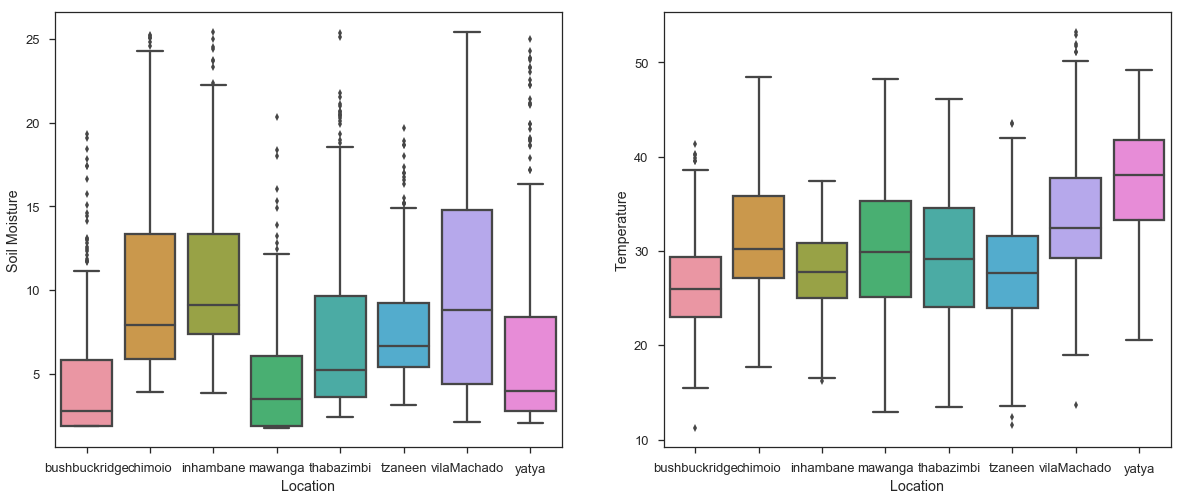

In [15]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(x='Location', y='Soil Moisture', ax=axes[0], data=smos_plot_data);
sns.boxplot(x='Location', y='Temperature', ax=axes[1], data=temp_plot_data);

In [16]:
import matplotlib.dates as mdates

def plot_timeseries(location='thabazimbi'):
    datemin, datemax = data.index[0], data.index[-1]
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(20,15))
    # Plot the data
    axes[0].plot(data['temp', location].dropna(), 'ro-')
    axes[0].set(ylabel='Temperature (degrees Celsius)', xlim=(datemin, datemax), title=location.capitalize())
    axes[1].plot(data['smos', location].dropna(), 'bo-')
    axes[1].set(xlabel='Date', ylabel='Soil Moisture')
    # Identify ideal mosquito-bearing temperatures in blue, maximum survivable temperature in black
    axes[0].hlines(40, datemin, datemax)
    axes[0].axhspan(25, 30, color='b', alpha=0.1)
    # Highlight historical reported outbreaks (see outbreaks.xlsx)
    if location == 'bushbuckridge':
        axes[0].axvspan('2017-05-11', '2017-05-25', color='g', alpha=0.1)
        axes[1].axvspan('2017-05-11', '2017-05-25', color='g', alpha=0.1)
    elif location == 'inhambane': # Outbreak outside data range
        axes[0].axvspan('2019-01-30', '2019-02-13', color='g', alpha=0.1)
        axes[1].axvspan('2019-01-30', '2019-02-13', color='g', alpha=0.1)
    elif location == 'thabazimbi':
        axes[0].axvspan('2017-02-28', '2017-03-14', color='g', alpha=0.1)
        axes[1].axvspan('2017-02-28', '2017-03-14', color='g', alpha=0.1)    
    elif location == 'vilaMachado': # Outbreak outside data range
        axes[0].axvspan('2019-03-13', '2019-03-27', color='g', alpha=0.1)
        axes[1].axvspan('2019-03-13', '2019-03-27', color='g', alpha=0.1)    
    elif location == 'yatya':
        axes[0].axvspan('2018-01-26', '2018-02-09', color='g', alpha=0.1)
        axes[1].axvspan('2018-01-26', '2018-02-09', color='g', alpha=0.1)
    # Format x-axis ticks
    axes[1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[0].grid(True)
    axes[1].grid(True)
    fig.autofmt_xdate()

In the figure below we plot the evolution of land surface temperature and soil moisture over time at each of the study locations, highlighting a temperature band between 25-30 degrees Celsius. Where possible, we also highlight a 14 day period leading up to a reported malaria outbreak in a given location, if present.

Recall the following factors suggested to influence malaria-transmitting mosquito populations:
1. Temperature
  - Ideal hatching water temperature: 24-30 degrees C
  - Ideal evolution from hatching water temperature: 22-26 degrees C
  - Optimum air temperature for malaria-bearing mosquitoes: 25-30 degrees C
  - Mosquitos typically don't survive below 15 degrees C nor above 40 degrees C
2. Standing Water
  - Mosquito eggs take 10-14 days to incubate
  - Frequency and amplitude of rainfall
  - Should take evaporation rates, humidity into account
  - Could use radar altimetry to detect large bodies of water, as well as meteorological data, soil moisture as proxy

In [17]:
interact(plot_timeseries, location=data['temp'].columns);

A Jupyter Widget

Comments:
- Data from most outbreak locations exhibit the anticipated behaviour of malaria outbreaks occuring following a spike in the soil moisture data (suggesting recent precipitation) around a week earlier along with favourable temperatures for mosquito incubation;
- However the timing of the reported malaria outbreak in Yatya does not follow this pattern. Yatya is an equatorial settlement in Kenya's Rift Valley Province, with typically higher temperatures than the other study locations. Land temperatures seem to be negatively correlated with soil moisture (i.e. rainfall reducing land temperatures and increasing soil moisture). The reported malaria outbreak appears to occur during a prolonged dry spell towards the end of winter, when conditions in mid-March of 2018 naively seem to be more conducive to a potential malaria outbreak.
- ~~Malaria outbreaks were reported at Inhambane and Vila Machado in early 2019, but these fall outside the range of our data measurements, so we cannot comment of their predictability based on temperature and soil moisture conditions.~~ Fixed by obtaining more data. Day 1 datasets only had measurements up to May 2018, but day 3 datasets provided measurements up to May 2019.
- Our temperature data is earth observation data for Daytime Land Surface Temperature at a spatial resolution of 1km. This probably doesn't perfectly reflect water and air temperatures, which are more relevant to mosquito habitability. This may possibly be used as an explanation for some of the unexpectedness of the Yatya outbreak.

## Conclusions
- It may be possible to retrospectively identify a malaria outbreak based on earth observation data such as (land surface) temperature and soil moisture, though such a model would be more predictive as we bring in more feature variables and data over a longer time period. The risk of confirmation bias based on a small number of samples should also be considered.
- For example, we could attribute an outbreak to recent rainfall and warm temperatures that are typical in the late African winter, however it's hard to say why similar outbreaks did not occur (or were not reported) at different times coinciding with a spike in soil moisture measurements, or at the locations where outbreaks were not reported.
- A more sophisticated model would use more information about the local terrain/land profile, proximity to lakes or sources of standing water. One should also consider human population density at each site since at present we are finding proxies for suitable mosquito habitat conditions, whilst the transmission of malaria will depend on the populations of both mosquitos and humans and their interactions. A mosquito becomes malaria-carrying (with some probability) if it interacts with an infected human, and humans become infected upon interacting with a malaria-carrying mosquito.
- One key recommendation would be to find or generate/commission a large dataset surveying the number of malaria cases over a large spatial scale (i.e. nation(s)-wide, but spatial resolution at the size of settlements/1km) over a number of years with temporal resolution of weeks or months. This would certainly be a resource-intensive undertaking, and data would be further complicated by the difference between malaria prevalence and reported new cases, though sampling the population could indicate prevalence since malaria is endemic in the locations of interest.

# Case study: Trends in malaria cases and precipitation in Nkomazi municipality, South Africa

We are provided with data on malaria cases and precipitation for the Nkomazi municipality of South Africa. The malaria data consists of monthly totals of reported malaria cases from January 2013 to August 2017. The malaria cases data was used in the paper _Predicting malaria cases using remotely sensed environmental variables in Nkomazi, South Africa_ which has also been included in this directory. The precipitation data is from a NASA cross sensor dataset for precipitation and has daily precipitation measurements for the period 2013-01-01 to 2017-08-31.

In [18]:
from __future__ import print_function
import os
# Please set the path below as per your system data folder location
data_path = ['data', 'nkomazi_municipality']

In [19]:
import numpy as np
import pandas as pd

cases_filepath = os.sep.join(data_path + ['nkomazi_malaria_cases_2013_2017.csv'])
precip_filepath = os.sep.join(data_path + ['nkomazi_precipitation.csv'])

cases = pd.read_csv(cases_filepath, sep='\t', header=None, names=['Date', 'Cases'], index_col=0, usecols=[0,1], parse_dates=True)
precipitation = pd.read_csv(precip_filepath, index_col=0, parse_dates=True)

In [20]:
# Monthly reported new malaria cases
cases.head()

Cases
Date             
2013-01-01      5
2013-02-01      4
2013-03-01      9
2013-04-01      2
2013-05-01      6

In [21]:
# Import plotting packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('dark')
sns.set(font_scale=2)

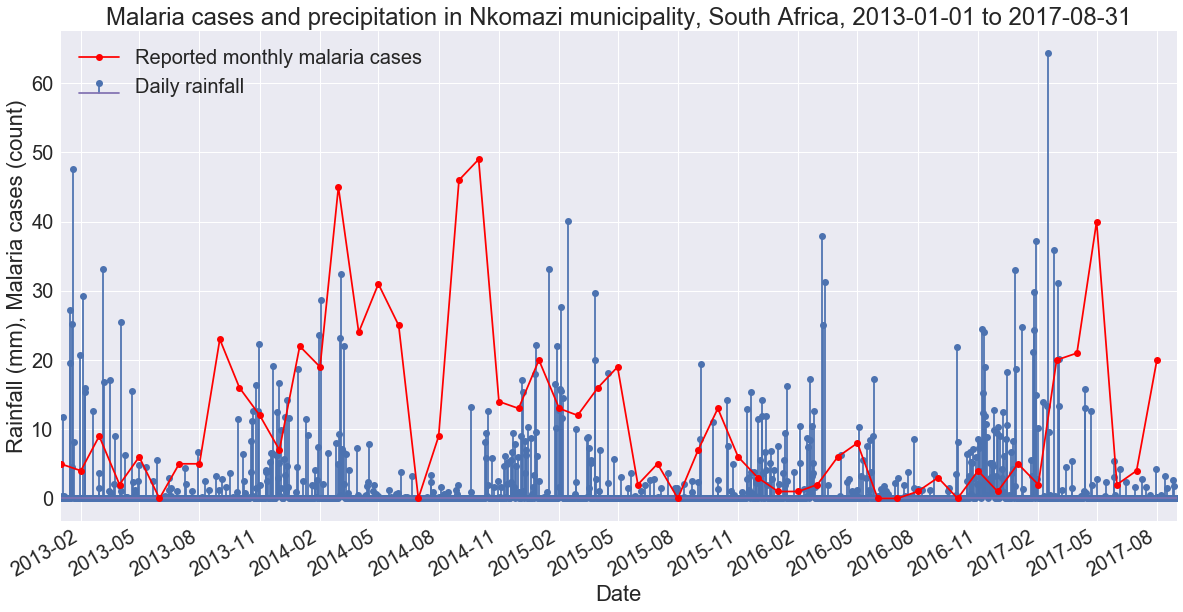

In [22]:
datemin, datemax = precipitation.index[0], precipitation.index[-1]
fig, axes = plt.subplots(figsize=(20,10))
axes.stem(precipitation.index, precipitation, label='Daily rainfall')
axes.plot(cases.index, cases, 'ro-', label='Reported monthly malaria cases')
axes.set(xlabel='Date', ylabel='Rainfall (mm), Malaria cases (count)', xlim=(datemin, datemax), 
         title='Malaria cases and precipitation in Nkomazi municipality, South Africa, 2013-01-01 to 2017-08-31')
axes.legend()
# Format x-axis ticks
axes.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Every three months
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes.xaxis.set_minor_locator(mdates.MonthLocator())
fig.autofmt_xdate()

# Can we use radar altimetry measurements to detect rainfall/standing water?

Data sources:
- Waveform data: [ESA's SENTINEL-3 Ku/C Radar Altimeter (SRAL)](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-altimetry/instrument/sral). Information on the two radar modes/resolutions provided by SRAL [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-altimetry/resolutions). You can get the data [here](https://scihub.copernicus.eu/dhus/#/home).
- Precipitation data: NASA cross sensor dataset for precipitation

Time in the first iteration of the waveform dataset was measured in International Atomic Time (TAI). We want to convert this to UTC to compare with the precipitation dataset. Click [here](https://opensource.com/article/17/5/understanding-datetime-python-primer) for more information on different time formats. Later datasets with UTC timestamps were provided.

```python
from astropy.time import Time
t = Time(waves.index, format='gps', scale='tai')
t.format = 'isot'
t.utc
```

As will be seen from the map plots later, the measurements from the first dataset can be grouped into three distinct clusters by location (longitude). Thus a second waveform dataset was provided with all of its measurements concentrated at a single location, at a crossover between two different relative orbits of the satellite.

In [23]:
from __future__ import print_function
import os
# Please set the path below as per your system data folder location
data_path = ['data', 'radar_precipitation']

In [24]:
import numpy as np
import pandas as pd

wave_filepaths = [os.sep.join(data_path + ['waveforms_utc_loc{}.csv'.format(i)]) for i in [1,2]]
precip_filepaths = [os.sep.join(data_path + ['precipitation_utc_loc{}.csv'.format(i)]) for i in [1,2]]

waves = [pd.read_csv(filepath, index_col=2, parse_dates=True).reset_index()
         .sort_values(by=['rel_orbit', 'time']).reset_index(drop=True) for filepath in wave_filepaths]
rainfall = [pd.read_csv(filepath, index_col=0, parse_dates=True).reset_index() for filepath in precip_filepaths]

Sometimes we have two measurements with the same timestamp but slightly different waveforms. This may be due to using two different radar modes (SAR mode and Low Resolution Mode (LRM)), or some other form of preprocessing. Unfortunately, we are unable to distinguish between the two given the provided datasets. To avoid repetition we could arbitrarily remove one of the measurements where duplicate timestamps are given.

In [25]:
for i in [0, 1]:
    print('Waveform dataset {} has {} rows, of which {} have unique timestamps, ranging from {} to {}.'
          .format(i, len(waves[i]), len(waves[i]['time'].unique()), 
                  waves[i]['time'].iloc[0].date(), waves[i]['time'].iloc[-1].date()))
    print('Precipitation dataset {} has {} daily rainfall measurements from {} to {}.'
          .format(i, len(rainfall[i]), rainfall[i]['date'].iloc[0].date(), rainfall[i]['date'].iloc[-1].date()))

Waveform dataset 0 has 123 rows, of which 100 have unique timestamps, ranging from 2016-04-24 to 2019-04-17.
Precipitation dataset 0 has 1140 daily rainfall measurements from 2016-02-16 to 2019-03-31.
Waveform dataset 1 has 113 rows, of which 90 have unique timestamps, ranging from 2016-04-20 to 2019-04-13.
Precipitation dataset 1 has 1140 daily rainfall measurements from 2016-02-16 to 2019-03-31.


In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets
%matplotlib inline

sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('dark')

In the cell below, we plot the daily rainfall data from the two datasets together in one figure. Each dataset has 1140 daily rainfall measurements from 2016-02-16 to 2019-03-31. Some seasonal trends can be seen: for example, the heaviest rainfall typically occurs between January and March each year. As the two locations are in relatively close proximity ([50-90km apart at similar latitudes in Mozambique](https://www.movable-type.co.uk/scripts/latlong.html)), their weather patterns are broadly similar although it seems that the location of the second dataset typically experiences heavy rain slightly more severely.

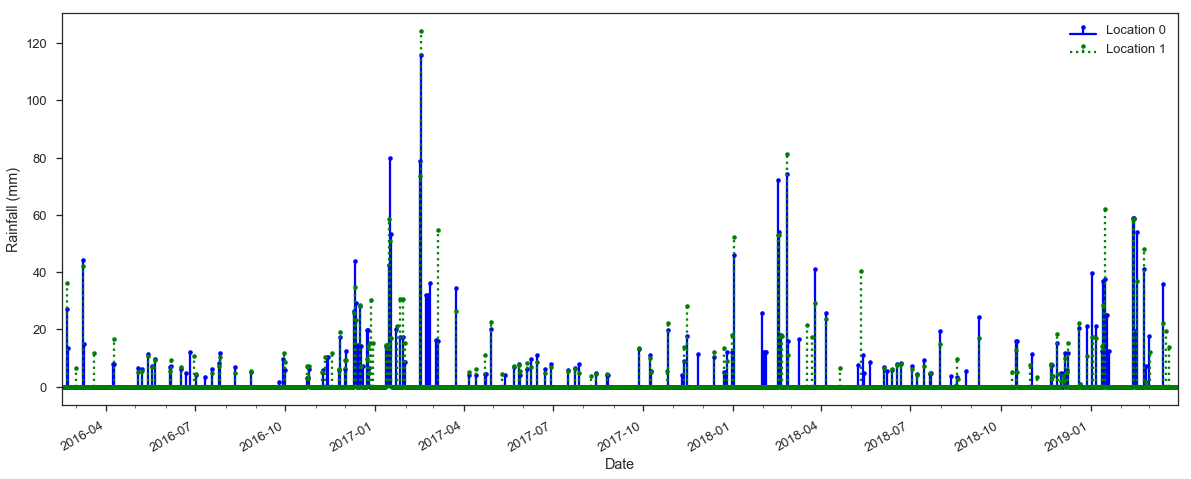

In [27]:
datemin, datemax = rainfall[0].iloc[0, 0], rainfall[0].iloc[-1, 0]
fig, axes = plt.subplots(figsize=(20,8))
for i in range(len(rainfall)):
    axes.stem(rainfall[i]['date'], rainfall[i]['precipitation'], 
              linefmt=('b-' if i == 0 else 'g:'), 
              markerfmt=('b.' if i == 0 else 'g.'),
              basefmt=('b-' if i == 0 else 'g:'),
              label='Location {}'.format(i));
axes.set(xlabel='Date', ylabel='Rainfall (mm)', xlim=(datemin, datemax))
axes.legend()
# Format x-axis ticks
axes.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Every three months
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes.xaxis.set_minor_locator(mdates.MonthLocator())
fig.autofmt_xdate()

## Create a widget to plot the waveform and rainfall data together. 

In [28]:
## Define the functions which form the backend of our widget, transforming inputs to outputs
# A helper function to colour the points in the map plot output
def col_by_rel_orbit(rel_orbit, location=-1):
    r"""Return a string containing a colour name depending on location and relative orbit values"""
    if location == 0:
        return 'red' if rel_orbit == 334 else 'blue'
    elif location == 1:
        return 'red' if rel_orbit == 277 else 'blue'
    else:
        return 'black'

# The primary backend function
def common_filtering(location, index):
    r"""
    Generate the widget outputs according to the passed dropdown values.
    """
    # Clear any existing outputs
    plots_output.clear_output()
    map_output.clear_output()
    # Get the row of data at the given index in the given dataset location
    datapoint = waves[location].iloc[index]
    # Get rainfall data for the 2 weeks leading up the the satellite measurement time of the datapoint 
    prev_two_weeks = rainfall[location].loc[(datapoint['time'] - pd.Timedelta(days=14) < rainfall[location]['date']) & 
                                (rainfall[location]['date'] <= datapoint['time'])].copy()
    
    # Plot the radar waveform measured by the satellite next to the past 2 weeks rainfall data
    with plots_output:
        f, axes = plt.subplots(1, 2, figsize=(15,8))
        # Set the figure title to be the time, location, and relative orbit of the satellite at the given datapoint
        f.suptitle('Measurement time = {}, \nLocation = ({}, {}), rel_orbit = {}'.format(datapoint['time'],
                                                                                            round(datapoint['lon'], 3),
                                                                                            round(datapoint['lat'], 3),
                                                                                            datapoint['rel_orbit']))        
        # Plot the radar waveform data
        axes[0].plot(range(128), datapoint.iloc[4:], label='Waveform')
        axes[0].set(xlabel='short time scale (~50ms)', ylabel='power', xlim=(0,127), ylim=(0,7000))
        axes[0].legend()
        # Create a bar chart for the rainfall data from the 2 weeks leading up to the radar waveform measurement
        if prev_two_weeks.empty:   
            axes[1].text(0.5, 0.5, 'Rainfall data unavailable for this period.', 
                         horizontalalignment='center', verticalalignment='center')
        else:
            prev_two_weeks.loc[:, 'date'] = prev_two_weeks['date'].apply(lambda x: x.date())
            prev_two_weeks.plot('date', 'precipitation', kind='bar', width=0.8, color='blue', ax=axes[1], ylim=(0, 130))
            axes[1].set(xlabel='Date', ylabel='Rainfall (mm)')
        plt.show() # Display the plots!
    
    # Produce a map of where radar waveform measurements were taken, highlighting the selected datapoint
    with map_output:
        # Plot the locations of all the measurements in the given dataset as points coloured by relative orbit
        ax = waves[location].plot.scatter('lon', 'lat', 
                   c=waves[location]['rel_orbit'].apply(lambda x: col_by_rel_orbit(x, location)), 
                   figsize=(10,10));
        # Mark a cross on the map at the location of the datapoint where we measured the radar waveform
        ax.scatter(datapoint['lon'], datapoint['lat'], marker='x', s=150,
            c=col_by_rel_orbit(datapoint['rel_orbit'], location));
        # Set the title to be the time, location, and relative orbit of the satellite at the given datapoint
        ax.set(xlabel='Longitude', ylabel='Latitude', 
                 title='Measurement time = {}, \nLocation = ({}, {}), rel_orbit = {}'.format(datapoint['time'],
                                                                                            round(datapoint['lon'], 3),
                                                                                            round(datapoint['lat'], 3),
                                                                                            datapoint['rel_orbit']))
        ax.set_aspect('equal')
        plt.show() # Display the map plot  

# Define the functions to execute upon observing a change in the dropdown menus
def dropdown_location_eventhandler(change):
    r"""
    When a change to the dataset dropdown is observed, we adjust the options for the index dropdown
    according to the number of rows/datapoints in the new dataset, reset the selected index to 0,
    and update the outputs according the dropdown values.
    """
    # Update index dropdown options according to the selected dataset
    dropdown_index.options = range(waves[change.new].shape[0])
    # Reset the index dropdown value to 0 when the dataset is changed to avoid index out-of-bounds errors.
    dropdown_index.value = 0 
    # Call the function to update the outputs
    common_filtering(change.new, dropdown_index.value)
    
def dropdown_index_eventhandler(change):
    r"""When a change to the index dropdown is observed, update the outputs according the new dropdown values"""
    common_filtering(dropdown_location.value, change.new)

## Build the widget frontend
# Initialize the dropdown menus
dropdown_location = widgets.Dropdown(options = [0,1], description='Dataset', value=0)
dropdown_index = widgets.Dropdown(options=range(waves[0].shape[0]), description='Index', value=0)

# Initialize the widget outputs
plots_output = widgets.Output()
map_output = widgets.Output()

# Design a dashboard to display the inputs and outputs
item_layout = widgets.Layout(margin='0 0 10px 0')
input_widgets = widgets.HBox([dropdown_location, dropdown_index], layout=item_layout)
tab = widgets.Tab([plots_output, map_output], layout=item_layout)
tab.set_title(0, 'Waveform, Rainfall')
tab.set_title(1, 'Datapoint map')
dashboard = widgets.VBox([input_widgets, tab], layout=item_layout)

# Attach the event handling functions to the dropdown menus
dropdown_location.observe(dropdown_location_eventhandler, names='value')
dropdown_index.observe(dropdown_index_eventhandler, names='value')

The user firsts selects the dataset they want to view, which were sampled from two different (nearby) locations in Mozambique, Africa, and then selects a row of waveform data, which have been sorted by the relative orbit (i.e. direction) of the satellite when taking the measurement and then then sorted by the date the measurement was taken.

After selecting a datapoint from a dataset, we display a plot of the radar waveform, as well as the recorded rainfall for the 14 days prior to the satellite radar measurement, along with the coordinates of the measurement location on the Earth's surface coloured by the relative orbit of the satellite at the time.

In [29]:
# Display the dashboard in a separate cell
display(dashboard)

A Jupyter Widget

## Future direction: Applying machine learning methods

Can perform dimensionality reduction using Principle Components Analysis (PCA) to reduce waveform data from 128 dimensions to, say, 2 or 3 dimensions, and then perform a clustering algorithm, say, k-means clustering, to potentially identify characteristic groups of waveforms.